## 작업환경을 현재 위치로 옮긴다.

In [2]:
import os
os.chdir(os.path.dirname(os.getcwd()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 필요한 패키지들을 불러온다.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, ReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam,SGD

In [5]:
from utils.datagenerator_girls_imgaug import TightFaceProvider
from utils.datagenerator_now import TightFaceProvider_Wally_Girl
from utils.helper_girls_imgaug import glob_all_files, paths2numpy, images_cropper, draw_rectangles
from utils.helper_girls_imgaug import show_images, cropper, random_patch, glob_all_files2

## 학습용 데이터를 만듭니다.

Max Height : 26 	 Min Height : 17
Max Width : 17 	 Min Width : 11
Max W/H Ratio : 0.9444444444444444 	 Min Ratio : 0.6111111111111112


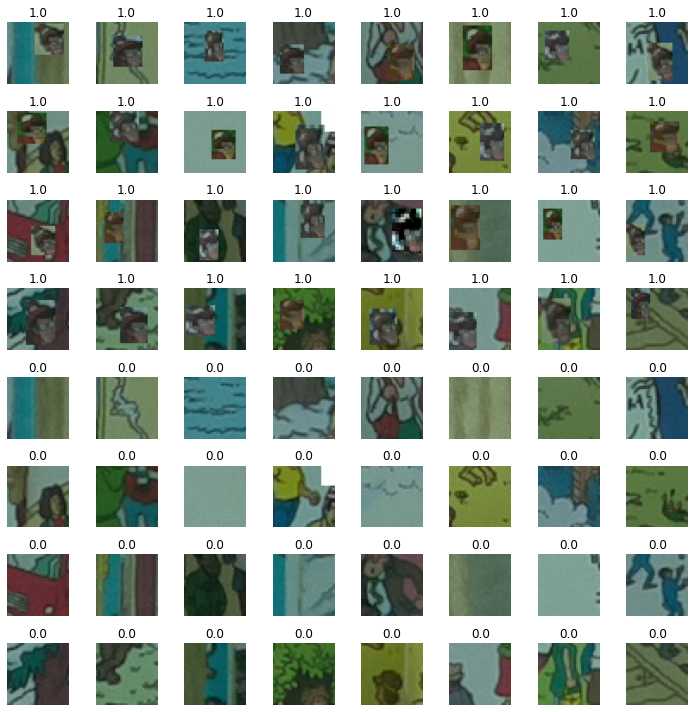

In [9]:
wally_folder = './data/train_imgs/waly_face/'
girl_folder = "./data/train_imgs/girl_face/"
bg_folder = './data/train_imgs/back_imgs/'

tfp = TightFaceProvider(wally_folder,bg_folder, batch_size=64)
show_images(tfp[4][0], titles=tfp[4][1].tolist())

## fine tuning용 데이터를 만듭니다.

Max Height : 26 	 Min Height : 17
Max Width : 17 	 Min Width : 11
Max W/H Ratio : 0.9444444444444444 	 Min Ratio : 0.6111111111111112


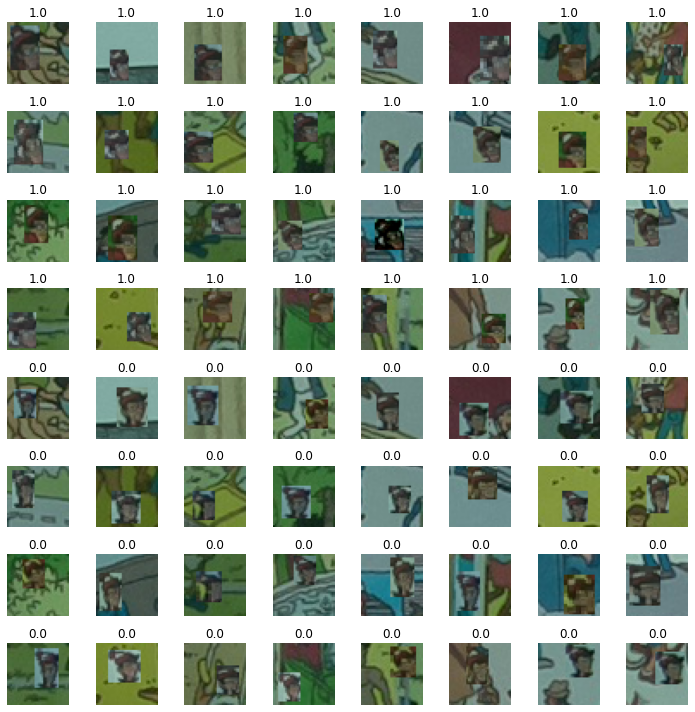

In [10]:
tfp_girl = TightFaceProvider_Wally_Girl(wally_folder,girl_folder,bg_folder, batch_size=64)
show_images(tfp_girl[4][0], titles=tfp_girl[4][1].tolist())

## 학습 모델을 구축한다.

In [6]:
inputs = Input(shape=(36, 36, 3), name='inputs')

conv = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(inputs)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

conv = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(pool)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

conv = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(pool)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

flat = Flatten()(pool)

#
fcn1 = Dense(units=256, kernel_initializer='he_normal')(flat)
norm = BatchNormalization()(fcn1)
relu = ReLU()(norm)

#
fcn2 = Dense(units=256, kernel_initializer='he_normal')(relu)
norm = BatchNormalization()(fcn2)
relu = ReLU()(norm)

#
pred = Dense(units=1, activation='sigmoid')(relu)

# Model
model = Model(inputs, pred)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

## 검증용 데이터를 불러옵니다.

In [12]:
# 학습과 함께 사용될 검증 데이터를 불러오는 부분
val_paths = ["./data/valid_imgs/back_imgs/","./data/valid_imgs/waly_face/"]

paths = glob_all_files2(val_paths)

# 검증용 이미지들을 가져온다
val_images = []
path_count = 0

for path in paths:
    images = paths2numpy(path)

    if not images:
        continue

    path_count += 1
    val_images.append(images)

assert path_count > 0, print("올바른 경로가 아니거나, 모든 경로 내에 검증용 이미지가 존재하지 않습니다.")

# 검증용 라벨들을 만든다
val_labels = []
for i in range(path_count):
    val_labels.extend(np.full(len(val_images[i]), i))

# list 형태의 test_images unlist 해주는 부분
val_images = [y for x in val_images for y in x]

val_images = np.array(val_images)
val_labels = np.array(val_labels)

## 모델을 학습시킨다.

In [8]:
model.fit(tfp, epochs=3, validation_data=(val_images, val_labels))

Epoch 1/3
5582/5582 [==============================] - 501s 90ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 2/3
5582/5582 [==============================] - 499s 89ms/step - loss: 6.2421e-04 - accuracy: 0.9998 - val_loss: 0.0049 - val_accuracy: 0.9989
Epoch 3/3
5582/5582 [==============================] - 498s 89ms/step - loss: 2.6343e-04 - accuracy: 0.9999 - val_loss: 0.0035 - val_accuracy: 0.9995


## 모델을 저장한다.

In [9]:
model.save("./models/model_test")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/model_test/assets


## 이미 저장된 모델이 있을 경우, 그 모델을 불러온다.

In [6]:
model = load_model("./models/model_test")

## 불러온 모델에 fine tuning 데이터를 학습시킵니다.

In [13]:
# 모델의 훈련 여부를 정합니다. True이면 가중치의 훈련이 가능해집니다.
model.trainable = True
# 최적화기법은 default 상태의 Adam을 사용하면 loss가 줄지않으면서 학습이 안되기에 사용하지 않았고, momentum
model.compile(optimizer=SGD(learning_rate=1e-5),  # Very low learning rate
              loss="binary_crossentropy",
              metrics=["accuracy"])

# fine tuning 데이터를 기존의 모델에 학습시킵니다.
model.fit(tfp_girl, epochs=1, validation_data=(val_images, val_labels))

2395/5582 [===========>..................] - ETA: 4:46 - loss: 1.5813 - accuracy: 0.8119

KeyboardInterrupt: 

## 검증용 데이터를 불러온다.

In [7]:
val_folder = "./data/test_imgs/"
paths = glob_all_files(val_folder)

assert paths, print("올바른 경로가 아니거나, 경로 내에 검증용 이미지가 존재하지 않습니다.")


imgs = paths2numpy(paths)

bucket_crop_imgs, bucket_crop_crds = images_cropper(imgs, 10, 10, 36, 36)

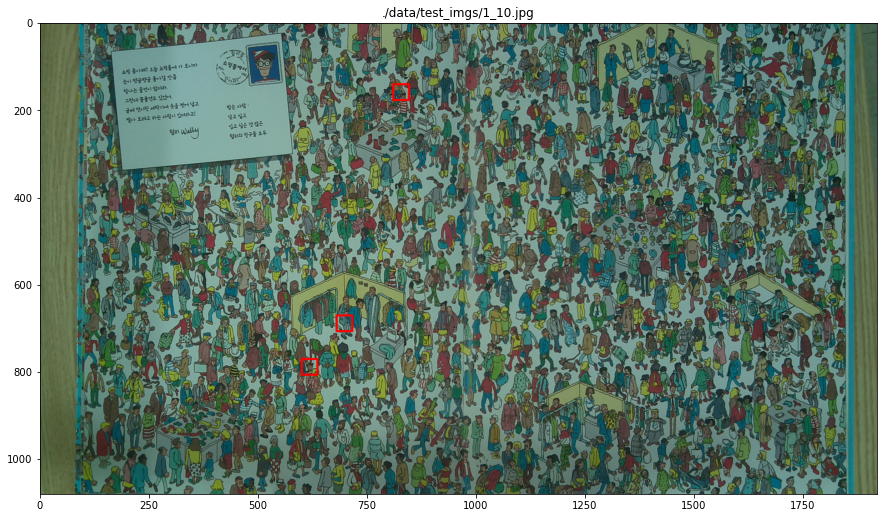

In [8]:
for i, img in enumerate(imgs):
    cropped_imgs = bucket_crop_imgs[i]
    cropped_crds = bucket_crop_crds[i]

    # 예측값을 저장한 후, 그 중 0.5가 넘는 값들에 대한 불리언 마스크를 만드는 부분입니다.
    predicts = model.predict(cropped_imgs)
    bool_mask = (predicts > 0.5)[:, 0]

    #show_images(cropped_imgs[bool_mask])    # 불리언 마스크를 적용시킨 결과로 얻은 월리의 얼굴로 추정되는 이미지 조각들을 출력
    target_crds = np.array(cropped_crds)[bool_mask]     # 월리의 얼굴이 있을 것으로 예상되는 좌표들을 저장

    predicts = predicts[bool_mask]  # 불리언 마스크를 적용시켰을 때의 예측값을 저장
    result_image = draw_rectangles(img, target_crds, (255, 0, 0), 3, predicts[:, 0])
    
    plt.figure(figsize=(15, 15))
    plt.title(paths[i])
    plt.imshow(result_image)
    plt.show()

## 모델을 검증용 데이터로 테스트합니다.

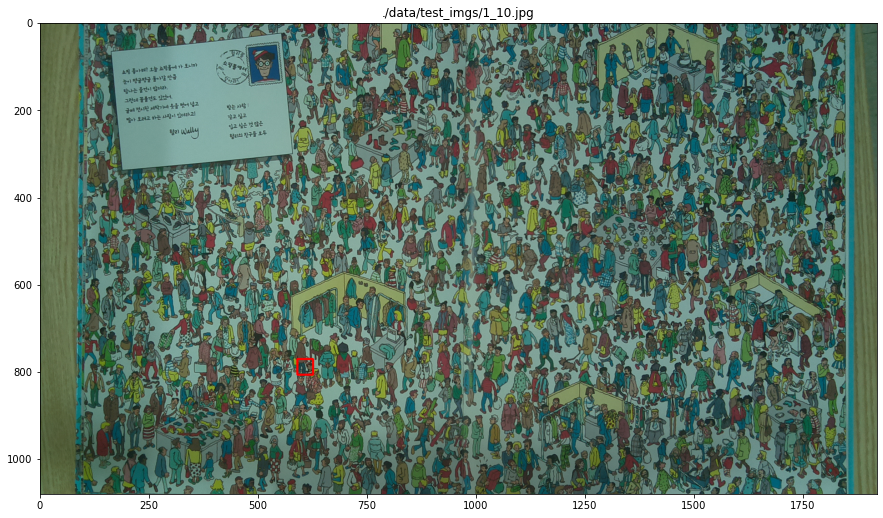

In [15]:
for i, img in enumerate(imgs):
    cropped_imgs = bucket_crop_imgs[i]
    cropped_crds = bucket_crop_crds[i]

    # 예측값을 저장한 후, 그 중 0.5가 넘는 값들에 대한 불리언 마스크를 만드는 부분입니다.
    predicts = model.predict(cropped_imgs)
    bool_mask = (predicts > 0.5)[:, 0]

    #show_images(cropped_imgs[bool_mask])    # 불리언 마스크를 적용시킨 결과로 얻은 월리의 얼굴로 추정되는 이미지 조각들을 출력
    target_crds = np.array(cropped_crds)[bool_mask]     # 월리의 얼굴이 있을 것으로 예상되는 좌표들을 저장

    predicts = predicts[bool_mask]  # 불리언 마스크를 적용시켰을 때의 예측값을 저장
    result_image = draw_rectangles(img, target_crds, (255, 0, 0), 3, predicts[:, 0])
    
    plt.figure(figsize=(15, 15))
    plt.title(paths[i])
    plt.imshow(result_image)
    plt.show()
